In [1]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture 
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

num_metastructures = 50

2024-09-04 18:16:19.033851: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-04 18:16:19.076322: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load_weights(directory, num_metastructures):
    log_weights = []
    lp = []
    files = sorted(os.listdir(directory))[-4:]
    print(files)
    
    log_weights_d = []
    for file in files:
        log_weights_chain = []
        lp_chain = []
        with open('%s/%s'%(directory, file), newline='') as csvfile:
            reader = csv.DictReader(filter(lambda row: row[0]!='#', csvfile), )
            for row in reader:
                log_weights_row = [float(row["log_weights.%d"%i]) for i in range(1,num_metastructures+1)]
                lp_chain.append(float(row["lp__"]))
                log_weights_chain.append(log_weights_row)
        log_weights = np.array(log_weights_chain)
        lp_chain = np.array(lp_chain)
        log_weights_d.append(log_weights)
        lp.append(lp_chain)
    log_weights_d = np.array(log_weights_d)
    return log_weights_d 

In [17]:
def load_weights(directory, num_metastructures):
    log_weights = []
    lp = []
    files = sorted(os.listdir(directory))[-4:]
    print(files)
    
    log_weights_d = []
    for file in files:
        log_weights_chain = []
        lp_chain = []
        with open('%s/%s'%(directory, file), newline='') as csvfile:
            reader = csv.DictReader(filter(lambda row: row[0]!='#', csvfile), )
            for row in reader:
                log_weights_row = [float(row["log_weights.%d"%i]) for i in range(1,num_metastructures+1)]
                lp_chain.append(float(row["lp__"]))
                log_weights_chain.append(log_weights_row)
        log_weights = np.array(log_weights_chain)
        lp_chain = np.array(lp_chain)
        log_weights_d.append(log_weights)
        lp.append(lp_chain)
    log_weights_d = np.array(log_weights_d)
    return log_weights_d 

common_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20240904_WeightMCMC_AllPCs_Marginals_001Quantile'

stan_directory_esc = os.path.join(common_dir, 'ESC/')
stan_directory_cnc = os.path.join(common_dir, 'CNC/')

# List all folders in the directory
folders_esc = os.listdir(stan_directory_esc)
folders_cnc = os.listdir(stan_directory_cnc)




In [18]:
# Sort the folders by the number of metastructures
num_folders = 2
folders_esc = sorted(folders_esc, key=lambda x: int(x[2:]))[:num_folders]
folders_cnc = sorted(folders_cnc, key=lambda x: int(x[2:]))[:num_folders]

In [19]:
stan_directory_esc_all = [os.path.join(stan_directory_esc, folder, 'stan_output') for folder in folders_esc]
stan_directory_cnc_all = [os.path.join(stan_directory_cnc, folder, 'stan_output') for folder in folders_cnc]

In [20]:

esc_log_weights = [load_weights(x, num_metastructures) for x in stan_directory_esc_all]
cnc_log_weights = [load_weights(x, num_metastructures) for x in stan_directory_cnc_all]

['20240715_WeightOptimization-20240904191129_1.csv', '20240715_WeightOptimization-20240904191129_2.csv', '20240715_WeightOptimization-20240904191129_3.csv', '20240715_WeightOptimization-20240904191129_4.csv']
['20240715_WeightOptimization-20240904191208_1.csv', '20240715_WeightOptimization-20240904191208_2.csv', '20240715_WeightOptimization-20240904191208_3.csv', '20240715_WeightOptimization-20240904191208_4.csv']
['20240715_WeightOptimization-20240904191146_1.csv', '20240715_WeightOptimization-20240904191146_2.csv', '20240715_WeightOptimization-20240904191146_3.csv', '20240715_WeightOptimization-20240904191146_4.csv']
['20240715_WeightOptimization-20240904191233_1.csv', '20240715_WeightOptimization-20240904191233_2.csv', '20240715_WeightOptimization-20240904191233_3.csv', '20240715_WeightOptimization-20240904191233_4.csv']


In [21]:
esc_weights_all = np.exp(np.array(esc_log_weights))
cnc_weights_all = np.exp(np.array(cnc_log_weights))

In [22]:
esc_weights_all.shape

(2, 4, 1000, 50)

In [35]:
esc_weights_all[0].reshape(-1, num_metastructures).shape

(4000, 50)

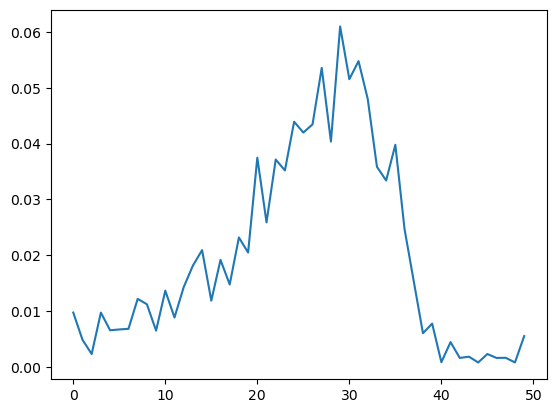

In [24]:
plt.plot(np.mean(esc_weights_all[0].reshape(-1, num_metastructures), axis=0))

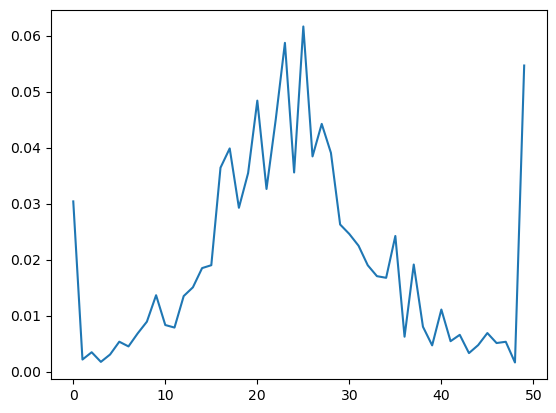

In [30]:
plt.plot(np.mean(esc_weights_all[1].reshape(-1, num_metastructures), axis=0))

In [25]:
esc_entropy_all = []
cnc_entropy_all = [] 

for i in range(esc_weights_all.shape[0]):
    esc_weights_reshape = esc_weights_all[i].reshape(-1, num_metastructures)
    esc_entropy = np.array([scipy.stats.entropy(x) for x in esc_weights_reshape])
    esc_entropy_all.append(esc_entropy)
    
for i in range(cnc_weights_all.shape[0]):
    cnc_weights_reshape = cnc_weights_all[i].reshape(-1, num_metastructures)
    cnc_entropy = np.array([scipy.stats.entropy(x) for x in cnc_weights_reshape])
    cnc_entropy_all.append(cnc_entropy)

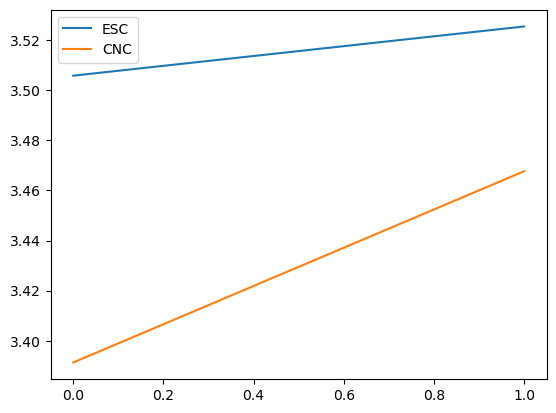

In [26]:
plt.plot([np.mean(x) for x in esc_entropy_all], label='ESC')
plt.plot([np.mean(x) for x in cnc_entropy_all], label='CNC')
plt.legend()

In [27]:
esc_entropy_mean_all = [np.mean(x) for x in esc_entropy_all]
cnc_entropy_mean_all = [np.mean(x) for x in cnc_entropy_all]

In [28]:
np.sum(esc_entropy_mean_all[:2])

7.031277230478036

In [29]:
np.sum(cnc_entropy_mean_all[:2])

6.8589825849320984